In [3]:
from IPython.display import display, HTML

# URL of the image
image_url = "https://gyanok.com/wp-content/uploads/2024/02/can-you-guess-the-netflix-show-by-the-emojis.jpg"

# HTML code to center the image
image_html = f'<div style="text-align: center;"><img src="{image_url}" width="853" height="479"></div>'

# Display the centered image
display(HTML(image_html))

# Introduction

### Exploring Movies Available on Netflix: Insights from TMDB Data

Welcome to my deep-dive analysis of **movies currently available on Netflix**, using a [large dataset](https://www.kaggle.com/datasets/alanvourch/tmdb-movies-daily-updates) I created from The Movie Database (TMDB). This dataset is updated daily and filtered to focus on titles that are **available on Netflix**, regardless of whether Netflix produced them.

### Context

Netflix has fundamentally transformed the entertainment industry, shifting the paradigm from theatrical-first to streaming-first. With a global subscriber base of over 300 million users and a yearly content budget surpassing \$17 billion, Netflix is not just a platform—it’s a global content distributor. While box office figures don’t fully reflect its performance, Netflix's content strategy blends original IP, local content, and global licensing deals.

### Objectives

This notebook aims to uncover content patterns, audience behavior, and creative signals from Netflix's current catalog through a series of data-driven visual explorations:

1. **Genre Trends**: Which genres dominate in volume, rating, and engagement?
2. **Origin Language**: How do content characteristics and performance vary by language?
3. **Runtime Optimization**: What runtimes correlate with better ratings and more viewer engagement?
4. **Content Performance Quadrants**: Clustering movies based on IMDb votes and rating to identify hits, hidden gems, and more.
5. **Talent Analysis**: Who are the top-performing directors, producers, writers, and composers based on audience engagement and critical acclaim?
6. **Production Companies**: Which companies consistently produce popular or highly-rated content on the platform?

### Note

TMDB is a community-driven platform, and its data may vary in completeness or accuracy—especially for streaming services like Netflix. The **revenue and budget data refer to theatrical box office metrics**, which are not relevant for most Netflix titles. As a result, this analysis focuses on more **actionable variables such as ratings, vote counts, runtime, origin, and talent**.

This notebook is built for content strategy exploration and does not cover marketing impact or subscriber growth, though these are key elements in Netflix's overall strategy.

# 1. Set-up

In [4]:
import numpy as np # linear algebra
import csv
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.express as px
import plotly.graph_objects as go
import time
import warnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Add this line to suppress FutureWarnings

In [ ]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', none)

# # Set display option in pandas to show floats with thousand separators
pd.options.display.float_format = '{:,.1f}'.format

# # Display multiple Variables without print() statements
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Principal dataset 900k movies from TMDB
df_all = pd.read_csv("/kaggle/input/tmdb-movies-daily-updates/TMDB_all_movies.csv")

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078505 entries, 0 to 1078504
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1078505 non-null  int64  
 1   title                    1078492 non-null  object 
 2   vote_average             1078503 non-null  float64
 3   vote_count               1078503 non-null  float64
 4   status                   1078503 non-null  object 
 5   release_date             955389 non-null   object 
 6   revenue                  1078503 non-null  float64
 7   runtime                  1078503 non-null  float64
 8   budget                   1078503 non-null  float64
 9   imdb_id                  612626 non-null   object 
 10  original_language        1078503 non-null  object 
 11  original_title           1078493 non-null  object 
 12  overview                 887825 non-null   object 
 13  popularity               1078503 non-null 

In [ ]:
df_all.head(1)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
0,2,Ariel,7.1,340.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,fi,Ariel,A Finnish man goes to the city to find a job a...,9.4,NaN,"Comedy, Drama, Romance, Crime",Villealfa Filmproductions,Finland,suomi,"Eetu Hilkamo, Turo Pajala, Jorma Markkula, Han...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Aki Kaurismäki,NaN,7.4,"9,103.0",/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg


## 1.5 Create Netflix dataset

In [ ]:
df_netflix = pd.read_csv('/kaggle/input/full-netflix-dataset/data.csv')

In [ ]:
imdb_id_list = df_netflix[df_netflix['type'] == 'movie']['imdbId'].tolist()

In [ ]:
df_all = df_all.dropna(subset=['imdb_id'])
df = df_all[df_all['imdb_id'].isin(imdb_id_list)]

In [ ]:
df.shape

(15213, 28)

In [ ]:
df.isna().sum()

id                            0
title                         0
vote_average                  0
vote_count                    0
status                        0
release_date                  9
revenue                       0
runtime                       0
budget                        0
imdb_id                       0
original_language             0
original_title                0
overview                    239
popularity                    0
tagline                    8572
genres                      192
production_companies       1727
production_countries        713
spoken_languages            568
cast                        450
director                    160
director_of_photography    4577
writers                    1498
producers                  3216
music_composer             7236
imdb_rating                 164
imdb_votes                  164
poster_path                 182
dtype: int64

In [ ]:
df = df[
    (df['imdb_votes'] > 1000) & 
    (df['status'] == 'Released') & 
    (df['imdb_id'].notna()) & 
    (df['runtime'] >= 40) & 
    (df['runtime'] < 300)  
]

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


This section explores how the volume of full-length movies available on Netflix has evolved over time. 

By focusing on titles with over 1,000 IMDb votes, a valid runtime, and confirmed release status, we ensure the analysis reflects meaningful, viewer-relevant content rather than obscure or placeholder entries.

This trend gives a high-level view of Netflix’s growing catalog and helps contextualize content volume against programming strategies.


In [ ]:
df.shape

(8586, 28)

# 2. Data preprocessing <a class="anchor"  id="hdata"></a>

In [ ]:
# Define the columns to be displayed
col_min = ['title', 'release_date','budget', 'revenue', 'imdb_votes','imdb_id','production_companies']

In [ ]:
# Convert release_date to datetime if not already
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

In [ ]:
df['decade'] = (df['release_year'] // 10) * 10

In [ ]:
# Count the number of movies by decade
movie_count_by_decade = df.groupby('decade').size().reset_index(name='movie_count')

movie_count_by_decade

,decade,movie_count
0,1910,4
1,1920,6
2,1930,9
3,1940,18
4,1950,69
5,1960,88
6,1970,136
7,1980,225
8,1990,479
9,2000,1340


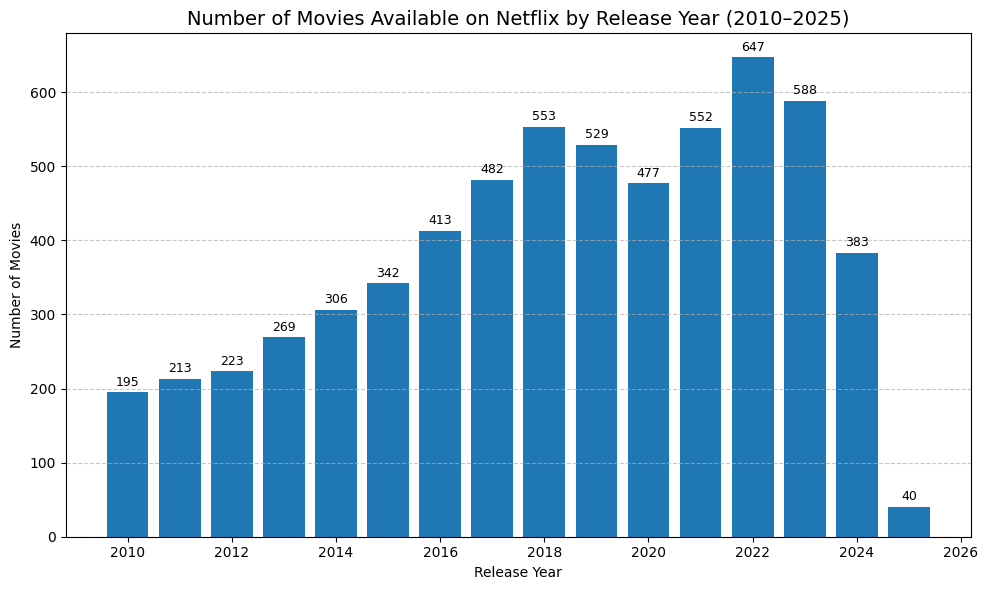

In [ ]:
df_recent = df[df['release_year'].between(2010, 2025)]

# Group by year
year_counts = df_recent['release_year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(year_counts.index, year_counts.values)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, int(yval), ha='center', va='bottom', fontsize=9)

plt.title("Number of Movies Available on Netflix by Release Year (2010–2025)", fontsize=14)
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show();

# 5. Genre Analysis

In [ ]:
import pandas as pd
import plotly.express as px

# Extract first genre only
df['main_genre'] = df['genres'].fillna('').apply(lambda x: x.split(',')[0].strip() if x else None)

# Count by main genre
genre_counts = df['main_genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Plot pie chart
fig = px.pie(
    genre_counts,
    names='genre',
    values='count',
    title='Netflix Movies by Main Genre',
    hole=0.3
)

fig.update_traces(textinfo='percent+label')
# fig.show(renderer='iframe')

In [ ]:
import plotly.express as px
import pandas as pd

# Filter to non-null genres, ratings, and votes
df_filtered = df[
    df["main_genre"].notnull() &
    df["imdb_votes"].notnull() &
    df["imdb_rating"].notnull()
].copy()

# Round imdb_votes
df_filtered["imdb_votes"] = df_filtered["imdb_votes"].round(0).astype(int)

# Sort genres by avg imdb_votes
sorted_genres_votes = (
    df_filtered.groupby("main_genre")["imdb_votes"]
    .mean()
    .sort_values(ascending=False)
    .index
)

# Boxplot: IMDb votes by main genre
fig_votes = px.box(
    df_filtered,
    x="main_genre",
    y="imdb_votes",
    title="IMDb Votes Distribution by Genre (Sorted by Avg Votes)",
    points="outliers",
    log_y=True,
    hover_data=["title", "imdb_rating", "release_year"],
    color="main_genre",
    category_orders={"main_genre": list(sorted_genres_votes)}
)
fig_votes.update_layout(xaxis_title="Genre", yaxis_title="IMDb Votes")

### 🎯 IMDb Votes by Genre

- **High outliers** (blockbusters) appear across most genres, but **Action**, **Fantasy**, and **Science Fiction** stand out with the **widest vote ranges** and **top outliers** — typical of globally appealing, franchise-heavy content.
- **Drama** and **Thriller** show a wide interquartile range, reflecting broad variability in audience reach.
- **Documentary**, **Family**, and **Music** have **tighter distributions** and lower medians, indicating **niche but focused engagement**.
- The **log scale** is essential here — vote counts range from a few thousand to several million.

In [ ]:
# Sort genres by avg imdb_rating
sorted_genres_ratings = (
    df_filtered.groupby("main_genre")["imdb_rating"]
    .mean()
    .sort_values(ascending=False)
    .index
)

# Boxplot: IMDb rating by main genre
fig_rating = px.box(
    df_filtered,
    x="main_genre",
    y="imdb_rating",
    title="IMDb Rating Distribution by Genre (Sorted by Avg Rating)",
    points="outliers",
    hover_data=["title", "imdb_votes", "release_year"],
    color="main_genre",
    category_orders={"main_genre": list(sorted_genres_ratings)}
)
fig_rating.update_layout(xaxis_title="Genre", yaxis_title="IMDb Rating")
fig_rating.show()

### 🎯 IMDb Rating by Genre

- **Documentary** leads with the **highest median rating** and a **tight, consistent distribution**, making it a reliable high-quality genre.
- **Drama**, **War**, and **Animation** also perform well, indicating strong storytelling and critical appeal.
- **Fantasy**, **Action**, and **TV Movie** tend to have **lower median ratings**, with more variability — suggesting these genres may favor reach over reception.
- This distribution highlights the trade-off between **mass appeal** and **audience satisfaction** in content strategy.

In [ ]:
import pandas as pd
import plotly.express as px
from scipy.stats import zscore

# Step 1: Extract main_genre from first genre
df["main_genre"] = df["genres"].dropna().apply(lambda x: x.split(",")[0].strip() if isinstance(x, str) else None)

# Step 2: Calculate average metrics per genre
genre_discrepancy = (
    df[df["main_genre"].notnull()]
    .groupby("main_genre")[["imdb_votes", "imdb_rating"]]
    .mean()
    .reset_index()
)

# Step 3: Normalize
genre_discrepancy["votes_z"] = zscore(genre_discrepancy["imdb_votes"])
genre_discrepancy["rating_z"] = zscore(genre_discrepancy["imdb_rating"])

# Step 4: Assign quadrant category
def classify_quadrant(row):
    if row["votes_z"] >= 0 and row["rating_z"] >= 0:
        return "🎯 High Popularity & High Rating"
    elif row["votes_z"] >= 0 and row["rating_z"] < 0:
        return "🔥 Popular but Lower Rated"
    elif row["votes_z"] < 0 and row["rating_z"] >= 0:
        return "💎 Underrated High Quality"
    else:
        return "🧊 Low Popularity & Low Rating"

genre_discrepancy["quadrant"] = genre_discrepancy.apply(classify_quadrant, axis=1)

# Step 5: Plot with quadrant colors
fig = px.scatter(
    genre_discrepancy,
    x="votes_z",
    y="rating_z",
    text="main_genre",
    color="quadrant",
    title="Genre Discrepancy: Popularity vs Quality (z-score Quadrants)",
    labels={
        "votes_z": "Popularity (IMDb Votes - z-score)",
        "rating_z": "Quality (IMDb Rating - z-score)"
    },
    color_discrete_map={
        "🎯 High Popularity & High Rating": "green",
        "🔥 Popular but Lower Rated": "yellow",
        "💎 Underrated High Quality": "blue",
        "🧊 Low Popularity & Low Rating": "red"
    }
)

# Add axis lines
fig.add_shape(type="line", x0=0, x1=0, y0=genre_discrepancy["rating_z"].min(), y1=genre_discrepancy["rating_z"].max(),
              line=dict(color="black", dash="dash"))
fig.add_shape(type="line", y0=0, y1=0, x0=genre_discrepancy["votes_z"].min(), x1=genre_discrepancy["votes_z"].max(),
              line=dict(color="black", dash="dash"))

fig.update_traces(textposition="top center", marker=dict(size=10, line=dict(width=1, color='black')))
fig.update_layout(height=700, width=900);

In [ ]:
fig.show()

# 6. Countries

In [ ]:
# Language mapping dictionary
language_mapping = {
    'en': 'English',
    'fr': 'French',
    'ja': 'Japanese',
    'es': 'Spanish',
    'ko': 'Korean',
    'hi': 'Hindi',
    'it': 'Italian',
    'sv': 'Swedish',
    'zh': 'Chinese',
    'de': 'German'
}

# Count occurrences of 'id' by 'original_language', then map the language names
top_languages = df.groupby('original_language')['id'].count()\
    .sort_values(ascending=False).head(10)

# Rename original language using the mapping
top_languages = top_languages.rename(language_mapping)

top_languages

original_language
English     4553
French       457
Japanese     416
Spanish      401
Korean       394
Hindi        379
Italian      225
Swedish      178
Chinese      152
German       139
Name: id, dtype: int64

In [5]:
import plotly.graph_objects as go

# Prepare main_genre and language columns
df["main_genre"] = df["genres"].fillna("").apply(lambda x: x.split(",")[0].strip() if isinstance(x, str) and x.strip() else None)
df_lang = df[df["original_language"].isin(language_mapping.keys())].copy()
df_lang["language_en"] = df_lang["original_language"].map(language_mapping)

# Build language-genre movie count matrix
heatmap_data = (
    df_lang.groupby(["main_genre", "language_en"])["id"]
    .count()
    .reset_index()
    .rename(columns={"main_genre": "genre", "id": "movie_count"})
)

heatmap_matrix = heatmap_data.pivot(index="genre", columns="language_en", values="movie_count").fillna(0)

# ✅ Column-normalize: highlight top genres per language
normalized_by_language = heatmap_matrix.div(heatmap_matrix.max(axis=0), axis=1).fillna(0)

sorted_languages = top_languages.index.tolist()
normalized_by_language = normalized_by_language[sorted_languages]


# Plot
fig = go.Figure(data=go.Heatmap(
    z=normalized_by_language.values,
    x=normalized_by_language.columns,
    y=normalized_by_language.index,
    colorscale="Blues",
    colorbar=dict(title="Relative Popularity (per language)"),
    zmin=0,
    zmax=1
))

fig.update_layout(
    title="Top Genres by Top 10 Origin Language (Column-Normalized Heatmap)",
    xaxis_title="Origin Language",
    yaxis_title="Genre",
    height=800,
    width=950,
    xaxis_tickangle=0
)
fig.show()

ModuleNotFoundError: No module named 'plotly'

### 🌍 Genre Preference by Original Language

This visualization uses **original spoken language** as a proxy for **content origin** and **audience genre preference**:

- 🌐 **English** is dominant in **Drama and Comedy** but also shows a more **globally balanced genre spread**.
- 🇯🇵 **Japan** is strongly skewed toward **Animation**, a unique signature compared to other languages.
- 🇮🇳 **Hindi** content is highly concentrated in **Drama, Comedy, and Action**, reflecting genre specialization.
- 🇩🇪 **German** and  **English** stand out for **Documentary** content, hinting at cultural preferences for non-fiction.
- ❤️ **Romance** is **evenly distributed** across all languages — suggesting it's a **universal genre** across cultures.
- ⚔️ **Korean and Chinese** content over-index on **Action**, showing strong genre identity.
- 🎭 **Drama**  and **Comedy** are the most consistent top genre across nearly every language.

This breakdown helps surface **strategic content patterns by region**, valuable for **localization**, **acquisition**, and **greenlighting** decisions.

In [ ]:
pd.set_option('display.max_colwidth', None)  # Remove column width limit

In [ ]:
# Create 'main_company' from first listed production company
df["main_company"] = df["production_companies"].fillna("").apply(
    lambda x: x.split(",")[0].strip() if isinstance(x, str) and x.strip() else None
)

# Filter to top 10 original languages only
df_lang = df[df["original_language"].isin(language_mapping.keys())].copy()
df_lang["language_en"] = df_lang["original_language"].map(language_mapping)

# Keep only top 10 languages
sorted_languages = top_languages.index.tolist()
df_lang_top = df_lang[df_lang["language_en"].isin(sorted_languages)]

# Build summary list
summary_rows = []
for lang in sorted_languages:
    df_subset = df_lang_top[df_lang_top["language_en"] == lang]

    # Top 3 main companies
    top_companies = df_subset["main_company"].value_counts().head(3).index.tolist()

    # Top director (with count)
    top_director_series = df_subset["director"].value_counts().head(1)
    top_director = (
        f"{top_director_series.index[0]} ({top_director_series.iloc[0]})"
        if not top_director_series.empty else "N/A"
    )

    # Most common genre
    top_genre = df_subset["main_genre"].value_counts().idxmax()

    # IMDb stats
    avg_rating = round(df_subset["imdb_rating"].mean(), 2)
    avg_votes = df_subset["imdb_votes"].mean()
    median_votes = df_subset["imdb_votes"].median()

    # Runtime
    avg_runtime = round(df_subset["runtime"].mean(), 1)

    # % of high-rated, high-vote movies
    df_high = df_subset[(df_subset["imdb_rating"] > 7) & (df_subset["imdb_votes"] > 10_000)]
    percent_high_rated = round(len(df_high) / len(df_subset) * 100, 1) if len(df_subset) > 0 else 0

    summary_rows.append({
        "language": lang,
        "top_director": top_director,
        "most_common_genre": top_genre,
        "avg_runtime_min": avg_runtime,
        "avg_imdb_rating": avg_rating,
        "avg_imdb_votes": f"{int(avg_votes):,}" if pd.notnull(avg_votes) else None,
        "median_imdb_votes": f"{int(median_votes):,}" if pd.notnull(median_votes) else None,
        "% high rated (>7 rating, >10k votes)": f"{percent_high_rated}%" if percent_high_rated else "0%",
        "top_3_main_companies": top_companies,
    })

# Create DataFrame
summary_table = pd.DataFrame(summary_rows)
summary_table

,language,top_director,most_common_genre,avg_runtime_min,avg_imdb_rating,avg_imdb_votes,median_imdb_votes,"% high rated (>7 rating, >10k votes)",top_3_main_companies
0,English,Steven Spielberg (19),Comedy,103.1,6.3,"106,014","30,112",17.0%,"[Columbia Pictures, Universal Pictures, Paramount Pictures]"
1,French,Jean Renoir (7),Comedy,103.0,6.5,"18,553","3,626",11.8%,"[Gaumont, StudioCanal, France 2 Cinéma]"
2,Japanese,Hayao Miyazaki (11),Animation,106.5,6.9,"21,053","3,541",19.2%,"[TOHO, Toei Animation, Studio Ghibli]"
3,Spanish,Pedro Almodóvar (20),Drama,103.5,6.3,"16,364","3,783",12.2%,"[El Deseo, Atresmedia, Vaca Films]"
4,Korean,Ryoo Seung-wan (9),Drama,117.8,6.7,"15,356","3,074",11.9%,"[CJ Entertainment, Lotte Entertainment, Next Entertainment World]"
5,Hindi,Anurag Kashyap (6),Drama,137.1,6.2,"22,727","11,412",24.5%,"[UTV Motion Pictures, Dharma Productions, T-Series]"
6,Italian,Paolo Sorrentino (8),Comedy,105.4,6.5,"13,787","3,243",12.0%,"[Medusa Film, Indigo Film, Wildside]"
7,Swedish,Ingmar Bergman (10),Comedy,104.8,6.2,"10,748","3,170",10.7%,"[SF Studios, Memfis Film, Film i Väst]"
8,Chinese,Zhang Yimou (8),Drama,116.4,6.6,"9,294","3,478",9.2%,"[China Film Group Corporation, Beijing New Picture Film Co. Ltd., Shanghai Film Group]"
9,German,Ed Herzog (7),Comedy,105.4,6.3,"15,161","3,166",9.4%,"[Constantin Film, Rat Pack Filmproduktion, Erma-Film]"


### 🎬 Key Insights by Original Language

- 🇺🇸 **English** leads in volume and reach: highest average IMDb votes (106k) and the third most high-rated titles (17%), driven by legacy studios and directors like **Spielberg**.
- 🇮🇳 **Hindi** has the **longest average runtime** (137 min) and **highest % of high-rated content** (24.5%)
- 🇯🇵 **Japanese** content confirmes its focus on **Animation** with 11 movies by director **Hayao Miyazaki** and a strong performance in the high-rated segment (19%).

# 7. Runtime

In [ ]:
import pandas as pd
import plotly.express as px

# Define runtime buckets
bins = [0, 60, 90, 120, float('inf')]
labels = ['<60 min', '60-90 min', '90-120 min', '120+ min']
df["runtime_bucket"] = pd.cut(df["runtime"], bins=bins, labels=labels, right=False)

# 1. Overall runtime distribution
fig_runtime_dist = px.histogram(
    df,
    x="runtime",
    nbins=50,
    title="Runtime Distribution of All Movies",
    labels={"runtime": "Runtime (minutes)"}
)

# 2. Runtime bucket vs IMDb rating
rating_by_bucket = (
    df.groupby("runtime_bucket")["imdb_rating"]
    .mean()
    .reset_index()
    .sort_values("imdb_rating", ascending=False)
)

# 3. Runtime bucket by genre count
df_genre_runtime = df[df["main_genre"].notnull()]
genre_bucket_counts = (
    df_genre_runtime.groupby(["main_genre", "runtime_bucket"])["id"]
    .count()
    .reset_index()
    .rename(columns={"id": "movie_count"})
)

fig_genre_dist = px.bar(
    genre_bucket_counts,
    x="main_genre",
    y="movie_count",
    color="runtime_bucket",
    barmode="group",
    title="Movie Count by Genre and Runtime Bucket",
    labels={"movie_count": "Number of Movies", "main_genre": "Genre", "runtime_bucket": "Runtime"}
)

fig_runtime_dist.show()
# fig_genre_dist.show()

# Filter for high-quality, high-engagement movies
df_success = df[
    (df["imdb_rating"] > 7) &
    (df["imdb_votes"] > 10_000) &
    df["runtime"].notnull()
]

# Plot histogram of runtimes
fig = px.histogram(
    df_success,
    x="runtime",
    nbins=40,
    title="Runtime Distribution of Successful Movies (IMDb > 7 and Votes > 10k)",
    labels={"runtime": "Runtime (minutes)", "count": "Number of Movies"},
)

fig.update_layout(
    bargap=0.05,
    height=600,
    width=900
)

### 🎯 Runtime Patterns in Successful Movies

This histogram shows the runtime distribution for movies with **IMDb rating > 7** and **more than 10,000 votes**.

- The distribution is clearly **shifted to the right**, meaning successful movies tend to have **longer runtimes**.
- Compared to the overall runtime distribution, this suggests that **audiences engage more** — and rate more highly — with content above **100 minutes**.
- This insight supports longer formats for high-impact storytelling, especially in drama.

In [ ]:
# Group by runtime buckets to compute average IMDb rating and votes
runtime_stats = (
    df.groupby("runtime_bucket")[["imdb_rating", "imdb_votes"]]
    .agg(avg_rating=("imdb_rating", "mean"), avg_votes=("imdb_votes", "mean"))
    .reset_index()
)

# Round results and format vote counts with commas
runtime_stats["avg_rating"] = runtime_stats["avg_rating"].round(2)
runtime_stats["avg_votes"] = runtime_stats["avg_votes"].apply(lambda x: f"{int(x):,}" if pd.notnull(x) else None)
runtime_stats

,runtime_bucket,avg_rating,avg_votes
0,<60 min,6.7,"3,882"
1,60-90 min,6.2,"22,847"
2,90-120 min,6.3,"49,482"
3,120+ min,6.8,"127,989"


In [ ]:
import plotly.express as px

# Filter valid entries
df_valid = df[
    df["runtime"].notnull() &
    df["imdb_rating"].notnull() &
    df["imdb_votes"].notnull()
]

# Create scatter plot with customdata
fig = px.scatter(
    df_valid,
    x="runtime",
    y="imdb_rating",
    size="imdb_votes",
    color="imdb_votes",
    custom_data=["title", "release_year", "imdb_rating", "imdb_votes"],
    title="Runtime vs IMDb Rating (Bubble Size = IMDb Votes)",
    labels={
        "runtime": "Runtime (minutes)",
        "imdb_rating": "IMDb Rating",
        "imdb_votes": "IMDb Votes"
    },
    size_max=30,
    color_continuous_scale="Viridis"
);

# Format hover with thousand separators + 'k'
fig.update_traces(
    hovertemplate=(
        "<b>%{customdata[0]}</b><br>" +
        "Year: %{customdata[1]}<br>" +
        "Rating: %{customdata[2]}<br>" +
        "Votes: %{customdata[3]:,.0f}<br>" +
        "Runtime: %{x} min"
    )
);

fig.update_layout(height=750, width=1000);

In [ ]:
fig.show()

### 🎯 Runtime vs IMDb Rating
- The scatter shows a clear **cluster of high-rated, high-voted movies** between **120–150 minutes**, confirming this as a strategic runtime window for critical and audience success.
- **Shorter movies (around 100 min)** are more frequent but tend to have **lower average ratings and fewer votes**.
- The **most voted titles** (largest bubbles) are concentrated in the **130–150 min** range and consistently score **above 8.0**.
- Very long runtimes (>180 min) are rare but also perform well when they exist — likely prestige or epic titles.

✅ This plot visually reinforces that **longer runtimes often correlate with both quality and engagement**, up to a point.


In [ ]:
# Recreate the fine runtime buckets
bins_fine = list(range(60, 181, 20)) + [float('inf')]
labels_fine = [f"{start}-{end} min" for start, end in zip(bins_fine[:-2], bins_fine[1:-1])] + ["180+ min"]
df["runtime_bucket_fine"] = pd.cut(df["runtime"], bins=bins_fine, labels=labels_fine, right=False)

# Filter valid rows
df_valid = df[df["runtime_bucket_fine"].notnull() & df["imdb_votes"].notnull() & df["imdb_rating"].notnull() & df["main_genre"].notnull()]

# Re-run the cleaned summary
genre_bucket_counted = df_valid.groupby(["main_genre", "runtime_bucket_fine"]).agg(
    avg_votes=("imdb_votes", "mean"),
    avg_rating=("imdb_rating", "mean"),
    movie_count=("id", "count")
).reset_index()

# Filter to only buckets with at least 10 movies
filtered_genre_bucket = genre_bucket_counted[genre_bucket_counted["movie_count"] >= 30]

# Most popular runtime (avg_votes)
idx_max_votes = filtered_genre_bucket.groupby("main_genre")["avg_votes"].idxmax()
top_votes_per_genre = filtered_genre_bucket.loc[idx_max_votes].set_index("main_genre")

# Highest rated runtime (avg_rating)
idx_max_rating = filtered_genre_bucket.groupby("main_genre")["avg_rating"].idxmax()
top_rating_per_genre = filtered_genre_bucket.loc[idx_max_rating].set_index("main_genre")

# Final table
summary_cleaned = pd.DataFrame({
    "most_popular_runtime": top_votes_per_genre["runtime_bucket_fine"],
    "avg_votes": top_votes_per_genre["avg_votes"].round(0).astype(int),
    "popular_sample_size": top_votes_per_genre["movie_count"],
    "highest_rated_runtime": top_rating_per_genre["runtime_bucket_fine"],
    "avg_rating": top_rating_per_genre["avg_rating"].round(2),
    "rating_sample_size": top_rating_per_genre["movie_count"]
}).reset_index()

summary_cleaned

,main_genre,most_popular_runtime,avg_votes,popular_sample_size,highest_rated_runtime,avg_rating,rating_sample_size
0,Action,140-160 min,191193,88,120-140 min,6.5,239
1,Adventure,120-140 min,262328,46,120-140 min,6.7,46
2,Animation,100-120 min,46334,112,100-120 min,7.0,112
3,Comedy,140-160 min,96416,45,60-80 min,6.9,187
4,Crime,120-140 min,106846,107,120-140 min,6.8,107
5,Documentary,100-120 min,9563,92,100-120 min,7.2,92
6,Drama,160-180 min,197518,49,160-180 min,7.2,49
7,Family,80-100 min,48822,85,80-100 min,5.9,85
8,Fantasy,100-120 min,120585,49,80-100 min,6.3,41
9,Horror,120-140 min,153924,35,120-140 min,6.4,35


### 🎬 Runtime Strategy Insights by Genre 

With a strict filter (≥30 movies per runtime bucket), we  highlight only **statistically robust patterns** across genres. Here are key takeaways:

- 🎭 **Drama** is the **only genre** with strong representation in **both popularity and quality** for movies **longer than 160 minutes**, suggesting audience and critical appreciation for deep, extended narratives.
- 👨‍👩‍👧 **Family** content performs **exclusively under 100 minutes**, indicating a strong preference for shorter runtimes that align with attention spans and viewing context.
- 😂 **Comedy** shows the **largest gap between engagement and quality**:
  - Most popular runtimes are **over 140 minutes**
  - Highest-rated runtimes are **under 80 minutes**
  This may reflect a divide between mainstream appeal (e.g. ensemble or rom-com hybrids) and tightly-written, critically acclaimed short comedies and probably stand-up specials.

These patterns emphasize the importance of **genre-specific runtime tuning**, not only for maximizing engagement but also for optimizing content perception and critical success.


In [ ]:
# Filter for Comedy movies in the 60–80 min runtime bucket
comedy_focus = df[
    (df["main_genre"] == "Comedy") &
    (df["runtime_bucket_fine"] == "60-80 min") &
    (df["imdb_rating"].notnull())
]

# Sort by IMDb rating descending and show top 10
comedy_top_10 = comedy_focus.sort_values("imdb_rating", ascending=False).head(10)
comedy_top_10[['title','release_year', 'imdb_votes', 'imdb_rating']]

,title,release_year,imdb_votes,imdb_rating
21550,Bill Hicks: Relentless,1992,"2,690.0",8.5
441139,Dave Chappelle: Sticks & Stones,2019,"28,516.0",8.3
267243,Bo Burnham: Make Happy,2016,"16,878.0",8.3
139722,Bo Burnham: What.,2013,"13,333.0",8.3
313007,Hasan Minhaj: Homecoming King,2017,"8,072.0",8.2
369384,Hannah Gadsby: Nanette,2018,"13,848.0",8.1
714888,Bo Burnham: The Inside Outtakes,2022,"2,146.0",8.1
175092,Jim Jefferies: Bare,2014,"5,946.0",8.0
441244,Bill Burr: Paper Tiger,2019,"13,033.0",8.0
13697,Richard Pryor: Live in Concert,1979,"5,991.0",8.0


### 🎤 Comedy 60–80 min: Stand-Up Special Sweet Spot

Looking at the **top 10 comedy titles** between **60–80 minutes**, sorted by IMDb rating:

- All top entries are **stand-up specials** or solo performances.
- These titles consistently score **above 8.0** with strong audience turnout (thousands to tens of thousands of votes).

✅ Confirms this runtime bucket is optimal for **stand-up content**, and likely inflates the overall average rating for the "Comedy" genre in short runtimes.

# 8. Top

## 8.1 Directors

In [ ]:
# Filter to movies with valid director and IMDb rating
df_directors = df[df["director"].notnull() & df["imdb_rating"].notnull()]

# Group by director: count, average rating, average votes
top_directors = (
    df_directors.groupby("director")
    .agg(
        movie_count=("id", "count"),
        avg_rating=("imdb_rating", "mean"),
        avg_votes=("imdb_votes", "mean")
    )
    .reset_index()
)

# Filter to directors with at least 5 movies
top_directors_filtered = top_directors[top_directors["movie_count"] >= 5]

# Format numbers
top_directors_filtered.loc[:, "avg_rating"] = top_directors_filtered["avg_rating"].round(2)
top_directors_filtered.loc[:, "avg_votes"] = top_directors_filtered["avg_votes"].fillna(0).round(0).astype(int)

# Sort by avg_rating descending
print('Top 10 Directors: Highest Rating')
top_directors_rating = top_directors_filtered.sort_values("avg_rating", ascending=False).reset_index(drop=True)
top_directors_rating.head(10)
print('Top 10 Directors: Most Votes')
top_directors_votes = top_directors_filtered.sort_values("avg_votes", ascending=False).reset_index(drop=True)
top_directors_votes.head(10)

Top 10 Directors: Highest Rating
Top 10 Directors: Most Votes


,director,movie_count,avg_rating,avg_votes
0,Christopher Nolan,10,8.3,"1,669,820.0"
1,Quentin Tarantino,8,8.0,"1,150,988.0"
2,Peter Jackson,6,8.1,"1,119,132.0"
3,Francis Ford Coppola,5,7.6,"791,341.0"
4,Denis Villeneuve,6,8.1,"743,896.0"
5,Martin Scorsese,13,7.8,"718,572.0"
6,David Fincher,10,7.6,"671,705.0"
7,Robert Zemeckis,10,7.2,"562,546.0"
8,Steven Spielberg,19,7.5,"555,370.0"
9,Todd Phillips,8,6.8,"538,200.0"


## 8.2 Producers

In [ ]:
df["producers"] = df["producers"].fillna("").apply(lambda x: [p.strip() for p in x.split(",")] if isinstance(x, str) else [])

In [ ]:
# Ensure producers are lists and explode them
df_exploded_producers = df.explode("producers")

# Filter for valid producer and rating
df_valid_producers = df_exploded_producers[
    df_exploded_producers["producers"].notnull() &
    df_exploded_producers["imdb_rating"].notnull()
]

# Group by producer: count, average rating, average votes
top_producers = (
    df_valid_producers.groupby("producers")
    .agg(
        movie_count=("id", "count"),
        avg_rating=("imdb_rating", "mean"),
        avg_votes=("imdb_votes", "mean")
    )
    .reset_index()
)

# Filter to producers with at least 5 movies
top_producers_filtered = top_producers[top_producers["movie_count"] >= 5].copy()

# Clean formatting
top_producers_filtered.loc[:, "avg_rating"] = top_producers_filtered["avg_rating"].round(2)
top_producers_filtered.loc[:, "avg_votes"] = top_producers_filtered["avg_votes"].fillna(0).round(0).astype(int)

# Sort by avg_rating
top_producers_sorted = top_producers_filtered.sort_values("avg_rating", ascending=False).reset_index(drop=True)

# Sort by avg_rating descending
print('Top 10 Producers: Highest Rating')
top_producers_rating = top_producers_sorted.sort_values("avg_rating", ascending=False).reset_index(drop=True)
top_producers_rating.head(10)
print('Top 10 Producers: Most Votes')
top_producers_votes = top_producers_sorted.sort_values("avg_votes", ascending=False).reset_index(drop=True)
top_producers_votes.head(10)

Top 10 Producers: Highest Rating
Top 10 Producers: Most Votes


,producers,movie_count,avg_rating,avg_votes
0,Emma Thomas,14,7.8,"1,293,851.0"
1,Christopher Nolan,13,7.7,"1,267,256.0"
2,Kevin De La Noy,6,7.2,"1,058,117.0"
3,Fran Walsh,7,7.8,"976,304.0"
4,Lorne Orleans,6,7.7,"922,006.0"
5,Mark Ordesky,7,7.3,"914,508.0"
6,Branko Lustig,5,8.0,"895,469.0"
7,Barrie M. Osborne,11,7.3,"839,620.0"
8,Michael Lynne,8,6.8,"814,387.0"
9,Lilly Wachowski,6,7.0,"806,970.0"


## 8.3 Writers & Composers

In [ ]:
df["writers"] = df["writers"].fillna("").apply(lambda x: [w.strip() for w in x.split(",")] if isinstance(x, str) else [])

In [ ]:
df["music_composer"] = df["music_composer"].fillna("").apply(lambda x: [m.strip() for m in x.split(",")] if isinstance(x, str) else [])

In [ ]:
# WRITERS — Ensure list format and explode

df_exploded_writers = df.explode("writers")

# Filter valid writers and votes
df_valid_writers = df_exploded_writers[
    df_exploded_writers["writers"].notnull() & df_exploded_writers["imdb_votes"].notnull()
]

# Group by writer
top_writers = (
    df_valid_writers.groupby("writers")
    .agg(
        movie_count=("id", "count"),
        avg_votes=("imdb_votes", "mean")
    )
    .reset_index()
)

# Filter for ≥5 movies
top_writers_filtered = top_writers[top_writers["movie_count"] >= 5]
top_writers_filtered.loc[:, "avg_votes"] = top_writers_filtered["avg_votes"].round(0).astype(int)

# Sort by avg_votes
top_5_writers = top_writers_filtered.sort_values("avg_votes", ascending=False).head(5)
print ('Top 5 Writers by votes')
top_5_writers

Top 5 Writers by votes


,writers,movie_count,avg_votes
5644,Jonathan Nolan,5,"2,023,257.0"
2037,Christopher Nolan,11,"1,593,647.0"
9330,Quentin Tarantino,8,"1,150,988.0"
3495,Fran Walsh,6,"1,137,144.0"
9161,Philippa Boyens,6,"1,137,144.0"


In [ ]:
# MUSIC COMPOSERS — Ensure list format and explode
df_exploded_composers = df.explode("music_composer")

# Filter valid composers and votes
df_valid_composers = df_exploded_composers[
    df_exploded_composers["music_composer"].notnull() &
    df_exploded_composers["imdb_votes"].notnull()
]

# Group by composer
top_composers = (
    df_valid_composers.groupby("music_composer")
    .agg(
        movie_count=("id", "count"),
        avg_votes=("imdb_votes", "mean")
    )
    .reset_index()
)

# Filter for ≥5 movies
top_composers_filtered = top_composers[top_composers["movie_count"] >= 5].copy()
top_composers_filtered.loc[:, "avg_votes"] = top_composers_filtered["avg_votes"].round(0).astype(int)
    
# Sort by avg_votes and get top 5
top_5_composers = top_composers_filtered.sort_values("avg_votes", ascending=False).head(5)
top_5_composers

,music_composer,movie_count,avg_votes
616,David Julyan,5,"725,244.0"
1018,Howard Shore,25,"526,627.0"
1278,John Williams,26,"505,531.0"
967,Hans Zimmer,57,"500,078.0"
1372,Jóhann Jóhannsson,6,"449,178.0"


## 8.4 Production Companies

In [ ]:
df["production_companies"] = df["production_companies"].fillna("").apply(lambda x: [p.strip() for p in x.split(",")] if isinstance(x, str) else [])

In [ ]:
# Ensure production_companies is parsed and exploded

df_exploded_companies = df.explode("production_companies")
df_exploded_companies = df_exploded_companies[df_exploded_companies["production_companies"].str.strip() != ""]

# Filter valid companies with votes and ratings
df_valid_companies = df_exploded_companies[
    df_exploded_companies["production_companies"].notnull() &
    df_exploded_companies["imdb_votes"].notnull() &
    df_exploded_companies["imdb_rating"].notnull()
]

# Group by company: avg votes and avg rating
company_stats = (
    df_valid_companies.groupby("production_companies")
    .agg(
        movie_count=("id", "count"),
        avg_votes=("imdb_votes", "mean"),
        avg_rating=("imdb_rating", "mean")
    )
    .reset_index()
)

# Filter to companies with at least 5 movies
company_stats_filtered = company_stats[company_stats["movie_count"] >= 100].copy()
company_stats_filtered.loc[:, "avg_votes"] = company_stats_filtered["avg_votes"].round(0).astype(int)
company_stats_filtered.loc[:, "avg_rating"] = company_stats_filtered["avg_rating"].round(2)

# Top 10 by avg_votes
top_10_votes = company_stats_filtered.sort_values("avg_votes", ascending=False).head(10)

# Top 10 by avg_rating
top_10_rating = company_stats_filtered.sort_values("avg_rating", ascending=False).head(10)

In [ ]:
print ('Top 10 Production Companies: Highest Rating (min count: 100 movies)')
top_10_rating

Top 10 Production Companies: Highest Rating (min count: 100 movies)


,production_companies,movie_count,avg_votes,avg_rating
8329,TOHO,102,"30,763.0",6.9
1398,CJ Entertainment,136,"14,254.0",6.7
9297,Warner Bros. Pictures,249,"301,273.0",6.6
6456,Paramount Pictures,175,"242,498.0",6.5
5960,New Line Cinema,109,"253,119.0",6.5
8158,StudioCanal,143,"53,896.0",6.4
1468,Canal+,121,"43,241.0",6.4
1877,Columbia Pictures,316,"182,185.0",6.4
9027,Universal Pictures,257,"178,726.0",6.3
4941,Lionsgate,160,"121,887.0",6.0


In [ ]:
print ('Top 10 Production Companies: Most Votes (min count: 100 movies)')
top_10_votes

Top 10 Production Companies: Most Votes (min count: 100 movies)


,production_companies,movie_count,avg_votes,avg_rating
9297,Warner Bros. Pictures,249,"301,273.0",6.6
5960,New Line Cinema,109,"253,119.0",6.5
6456,Paramount Pictures,175,"242,498.0",6.5
1877,Columbia Pictures,316,"182,185.0",6.4
9027,Universal Pictures,257,"178,726.0",6.3
4941,Lionsgate,160,"121,887.0",6.0
8158,StudioCanal,143,"53,896.0",6.4
1468,Canal+,121,"43,241.0",6.4
8329,TOHO,102,"30,763.0",6.9
1398,CJ Entertainment,136,"14,254.0",6.7
